In [ ]:
import os
from os import path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
# !pip install opencv-python==3.4.2.17
# !pip install opencv_contrib_python==3.4.2.17 --force-reinstall
import cv2 
from tensorflow.keras.preprocessing import image
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import scipy 
import skimage.measure 
from skimage.feature import hog
from sklearn.svm import SVC

# For classification.
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## ***HANDCRAFTED FEATURES***

In this notebook, we want to **classify** the type of cancer, i.e. malign or benign, from several mammography images. Once the region of cancer has been extracted with the provided mask, we can compute several features from this zoomed images, such as: 
- ***Basic statistics***: mean, standard deviation, entropy and skewness of pixels. 
- ***Local binary features***.
- ***Histogram oriented gradient***.

Then, we perform a *dimensionality reduction* with different techniques (PCA, LDA and PCA with non-linear kernel) and different number of componenets, eventually we have selected the last method with cosine kernel because models perform better. 

Finally, we use different *types of classifiers*, such as KNN, SVC, Logistic Regression, SGDClassifier and Random Forest. In order to find out the best parameters for each of them a GridSearch has been used. The accuracy of models reach a maximum value of about 74%. This is one of the best model for our classification task. However, performances aren't so satisfactory for several reasons:

1.  Handcrafted are built and not provided by, for instance, a neaural network. So, we make a specific choice of them but it isn't unique: indeed, SIFT keypoints (before clustering) should be used for this representation.
2. Informativeness of images are low: it's complex to work with them.
3. Number of images and computational resources.


In [ ]:
from skimage import feature
import numpy as np

class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

In [ ]:
# import csv data.
import pandas as pd
data = []
for j in range(1, 14):
  data.append(pd.read_csv('./gdrive/MyDrive/DSIM/HandcraftedFeatures/'+str(j)+'-Hand.csv', dtype={'CODE': 'str'}))

data = pd.concat(data, axis=0)
data.head()

,Unnamed: 0,CODE,LEFT,CC,BENING,PATIENT_AGE,DENSITY
0,0,0029,1,1,1,66,3
1,1,0029,1,0,1,66,3
2,2,0033,0,1,1,60,3
3,3,0033,0,0,1,60,3
4,4,0217,0,1,1,56,2


In [ ]:
# retrieve data path.
def retrieve_file(row):
  cancer, cc, code = row['BENING'], row['CC'], row['CODE']
  type_cancer = 'BenignFocus/' if cancer == 1 else 'MalignFocus/'
  type_view = 'CC/' if cc == 1 else 'MLO/'
  path = './gdrive/MyDrive/DSIM/' + type_cancer + type_view + 'Focus' + code + '.png'
  return path 

data['PATH'] = data.apply(lambda row: retrieve_file(row), axis = 1)
data.head()

,Unnamed: 0,CODE,LEFT,CC,BENING,PATIENT_AGE,DENSITY,PATH
0,0,0029,1,1,1,66,3,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0029...
1,1,0029,1,0,1,66,3,./gdrive/MyDrive/DSIM/BenignFocus/MLO/Focus002...
2,2,0033,0,1,1,60,3,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0033...
3,3,0033,0,0,1,60,3,./gdrive/MyDrive/DSIM/BenignFocus/MLO/Focus003...
4,4,0217,0,1,1,56,2,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0217...


In [ ]:
%%time

# Basic statistics.
def compute_mean(row):
  img = image.load_img(row['PATH'], target_size=(224, 224), color_mode='grayscale')
  img = image.img_to_array(img).flatten()
  return {'MEAN': np.mean(img), 'SKEW': scipy.stats.skew(img), 'ENTROPY':skimage.measure.shannon_entropy(img), 'STD':np.std(img)}

data['STATISTICS'] = data.apply(lambda row: compute_mean(row), axis = 1)

# split results into separate columns.
data_stat = data['STATISTICS'].apply(pd.Series)
data = pd.concat([data[:], data_stat[:]], axis=1)
data.drop(columns =['STATISTICS'], inplace = True)

CPU times: user 13.4 s, sys: 567 ms, total: 14 s
Wall time: 15min 22s


In [ ]:
data.head()

,Unnamed: 0,CODE,LEFT,CC,BENING,PATIENT_AGE,DENSITY,PATH,MEAN,SKEW,ENTROPY,STD
0,0,0029,1,1,1,66,3,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0029...,121.544701,-0.635382,7.275471,58.426701
1,1,0029,1,0,1,66,3,./gdrive/MyDrive/DSIM/BenignFocus/MLO/Focus002...,77.146103,-0.066453,7.087698,45.709446
2,2,0033,0,1,1,60,3,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0033...,162.600449,-1.639841,5.866811,23.779564
3,3,0033,0,0,1,60,3,./gdrive/MyDrive/DSIM/BenignFocus/MLO/Focus003...,125.931717,-0.906785,6.710093,36.105152
4,4,0217,0,1,1,56,2,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0217...,105.558136,-0.127112,5.688868,13.713251


In [ ]:
%%time

# Local binary descriptors.
def compute_lbd(row, lbd):
  img = image.load_img(row['PATH'], target_size=(224, 224))
  img = np.array(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  hist = lbp.describe(img)
  return hist

p = 16
r = 2
lbp = LocalBinaryPatterns(p, r)
data['LBD'] = data.apply(lambda row: compute_lbd(row, lbp), axis = 1)

data_lbd = data['LBD'].apply(pd.Series)

# Split list of LBD into separate columns.
data_lbd = data_lbd.rename(columns = lambda x : 'LBD_' + str(x))

data = pd.concat([data[:], data_lbd[:]], axis=1)

data.drop(columns =['LBD'], inplace = True)

In [ ]:
data.head()

In [ ]:
%%time 

# Compute hof for each image
def compute_orientation(row):
  img = image.load_img(row['PATH'], target_size=(224, 224), color_mode='grayscale')
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(32, 32),
                    cells_per_block=(4, 4), visualize=True, multichannel=False)

  # Rescale histogram for better display
  return fd

data['HOG'] = data.apply(lambda row: compute_orientation(row), axis = 1)

data_hog = data['HOG'].apply(pd.Series)

# Split list of LBD into separate columns.
data_hog = data_hog.rename(columns = lambda x : 'HOG_' + str(x))

data = pd.concat([data[:], data_hog[:]], axis=1)

data.drop(columns =['HOG'], inplace = True)

CPU times: user 39 s, sys: 588 ms, total: 39.6 s
Wall time: 41.5 s


In [ ]:
data.head()

,Unnamed: 0,CODE,LEFT,CC,BENING,PATIENT_AGE,DENSITY,PATH,MEAN,SKEW,ENTROPY,STD,LBD_0,LBD_1,LBD_2,LBD_3,LBD_4,LBD_5,LBD_6,LBD_7,LBD_8,LBD_9,LBD_10,LBD_11,LBD_12,LBD_13,LBD_14,LBD_15,LBD_16,LBD_17,HOG_0,HOG_1,HOG_2,HOG_3,HOG_4,HOG_5,HOG_6,HOG_7,HOG_8,HOG_9,...,HOG_2264,HOG_2265,HOG_2266,HOG_2267,HOG_2268,HOG_2269,HOG_2270,HOG_2271,HOG_2272,HOG_2273,HOG_2274,HOG_2275,HOG_2276,HOG_2277,HOG_2278,HOG_2279,HOG_2280,HOG_2281,HOG_2282,HOG_2283,HOG_2284,HOG_2285,HOG_2286,HOG_2287,HOG_2288,HOG_2289,HOG_2290,HOG_2291,HOG_2292,HOG_2293,HOG_2294,HOG_2295,HOG_2296,HOG_2297,HOG_2298,HOG_2299,HOG_2300,HOG_2301,HOG_2302,HOG_2303
0,0,0029,1,1,1,66,3,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0029...,121.544701,-0.635382,7.275471,58.426701,0.039062,0.032406,0.022461,0.021564,0.024255,0.033482,0.046118,0.063277,0.066187,0.066885,0.050482,0.039142,0.028998,0.026626,0.029357,0.030632,0.060945,0.318120,0.145202,0.072249,0.063994,0.066552,0.071001,0.072419,0.086348,0.114795,0.083860,0.123013,...,0.003556,0.023615,0.004623,0.001006,0.122523,0.106658,0.073768,0.071334,0.051622,0.037727,0.048491,0.047587,0.034360,0.109989,0.098631,0.106959,0.049361,0.031992,0.024300,0.019712,0.025251,0.019529,0.081839,0.035283,0.039726,0.023943,0.036577,0.012680,0.019915,0.015095,0.011985,0.053671,0.008534,0.039583,0.003556,0.033078,0.000711,0.018217,0.004267,0.000000
1,1,0029,1,0,1,66,3,./gdrive/MyDrive/DSIM/BenignFocus/MLO/Focus002...,77.146103,-0.066453,7.087698,45.709446,0.039720,0.034837,0.022899,0.022660,0.022581,0.030254,0.041354,0.054668,0.060866,0.060029,0.043846,0.036870,0.026666,0.030234,0.033024,0.033781,0.075295,0.330417,0.083552,0.041843,0.046552,0.061856,0.107074,0.106778,0.085817,0.080705,0.050066,0.066048,...,0.000917,0.014785,0.001375,0.000000,0.065849,0.031066,0.057664,0.050470,0.072378,0.027631,0.043415,0.015978,0.004286,0.063408,0.017344,0.052341,0.025544,0.058217,0.007982,0.028410,0.008251,0.002142,0.055175,0.014668,0.046964,0.011001,0.051247,0.006607,0.021453,0.004125,0.000000,0.061499,0.002750,0.016814,0.002292,0.076466,0.000000,0.008117,0.000000,0.019306
2,2,0033,0,1,1,60,3,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0033...,162.600449,-1.639841,5.866811,23.779564,0.058952,0.039880,0.030951,0.027503,0.024075,0.030632,0.034857,0.038126,0.037289,0.041753,0.033363,0.034020,0.029297,0.034977,0.040677,0.035754,0.085300,0.342594,0.089234,0.096049,0.123664,0.116401,0.092926,0.049243,0.033812,0.028281,0.029817,0.085997,...,0.091512,0.087027,0.055551,0.041816,0.093298,0.059211,0.076171,0.077495,0.090190,0.085859,0.080208,0.063665,0.031863,0.137001,0.084239,0.075426,0.086081,0.099653,0.079065,0.080113,0.071428,0.051366,0.116383,0.062301,0.071493,0.083893,0.148082,0.112325,0.084408,0.086809,0.054882,0.132599,0.066015,0.084919,0.108248,0.130204,0.093401,0.076962,0.062812,0.038568
3,3,0033,0,0,1,60,3,./gdrive/MyDrive/DSIM/BenignFocus/MLO/Focus003...,125.931717,-0.906785,6.710093,36.105152,0.049665,0.032864,0.030493,0.027882,0.029436,0.035635,0.041833,0.051399,0.054189,0.057418,0.045041,0.039601,0.033721,0.032924,0.034698,0.033382,0.062480,0.307338,0.075270,0.045107,0.044123,0.037638,0.048027,0.031963,0.038271,0.032868,0.020219,0.091611,...,0.089473,0.056383,0.051664,0.046151,0.072103,0.065549,0.073501,0.104929,0.137422,0.118808,0.097207,0.075195,0.037837,0.099814,0.065905,0.081648,0.122496,0.128688,0.089714,0.070999,0.069761,0.041604,0.085188,0.076324,0.094690,0.126075,0.121347,0.087730,0.063975,0.051509,0.040572,0.102116,0.082348,0.118061,0.142063,0.145840,0.083546,0.068488,0.054698,0.046527
4,4,0217,0,1,1,56,2,./gdrive/MyDrive/DSIM/BenignFocus/CC/Focus0217...,105.558136,-0.127112,5.688868,13.713251,0.065250,0.058514,0.035296,0.022162,0.016004,0.015266,0.017080,0.020169,0.020707,0.025191,0.019212,0.018933,0.020568,0.029755,0.042969,0.052396,0.096540,0.423988,0.074193,0.040375,0.059275,0.084438,0.107165,0.082921,0.072296,0.042043,0.016942,0.088931,...,0.118902,0.082133,0.055762,0.028331,0.068985,0.047877,0.075345,0.107663,0.121061,0.097559,0.064151,0.038091,0.03

In [ ]:
# Preprocess data.

#-------- ENCODING BINARY DATA 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['LEFT'] = le.fit_transform(data['LEFT'])
data['CC'] = le.fit_transform(data['CC'])
data['BENING'] = le.fit_transform(data['BENING'])

#-------- SPLIT DATASET
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[data.columns.difference(['BENING', 'CODE', 'PATH', 'Unnamed: 0'])], 
                                                    data.BENING,
                                                    test_size = 0.2, 
                                                    random_state = 1)

#-------- FEATURE SCALING
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train[['PATIENT_AGE']] = sc.fit_transform(x_train[['PATIENT_AGE']])
x_test[['PATIENT_AGE']] = sc.transform(x_test[['PATIENT_AGE']])

x_train[['MEAN']] = sc.fit_transform(x_train[['MEAN']])
x_test[['MEAN']] = sc.transform(x_test[['MEAN']])

#-------- FEATURE SELECTION.
# Applicare la PCA ad ognuna delle 3 tipologie di features.
from sklearn.decomposition import PCA

# pca = PCA(n_components = 200)
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# lda = LDA(n_components = 30)
# x_train = lda.fit_transform(x_train, y_train)
# x_test = lda.transform(x_test)

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 100, # number of final components
                kernel = 'cosine' # radial basis function
                ) 
x_train = kpca.fit_transform(x_train, y_train)
x_test = kpca.transform(x_test)

********************** KNN **********************
Accuracy:  0.6575091575091575
Confusion matrix:


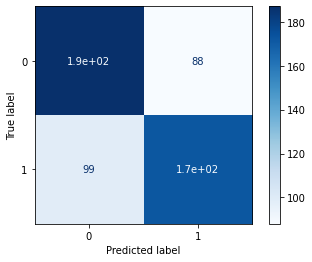

Best parameters: {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 11}
CPU times: user 7.89 s, sys: 342 ms, total: 8.23 s
Wall time: 47.4 s


In [ ]:
%%time

print('********************** KNN **********************')

# Selection of parameters.
parameters = {'n_neighbors':[3, 5, 7, 9, 11],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}    

# Define algorithm and GridSearch.
knn = KNeighborsClassifier() 

clf = GridSearchCV(knn, parameters, cv=5)
# Fir and prediction.
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

print('Best parameters:', clf.best_params_)
print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('Confusion matrix:')
plot_confusion_matrix(clf, x_test, y_test, cmap = 'Blues')  
plt.show() 

********************** SVC **********************
Best parameters: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
Accuracy:  0.6648351648351648
Confusion matrix:


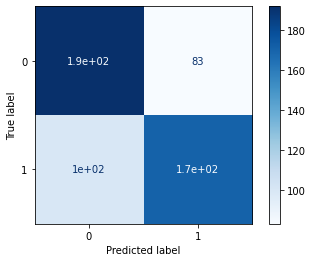

CPU times: user 1min 18s, sys: 22.1 ms, total: 1min 18s
Wall time: 1min 18s


In [ ]:
%%time 

print('********************** SVC **********************')
parameters = {'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              'kernel':['linear','rbf']}

from sklearn.svm import SVC
 
clf = GridSearchCV(SVC(), parameters, cv=5)
# Fir and prediction.
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

print('Best parameters:', clf.best_params_)
print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('Confusion matrix:')
plot_confusion_matrix(clf, x_test, y_test, cmap = 'Blues')  
plt.show() 

********************** Logistic Regression **********************
Best parameters: {'C': 100, 'penalty': 'l2'}
Accuracy:  0.6978021978021978
Confusion matrix:


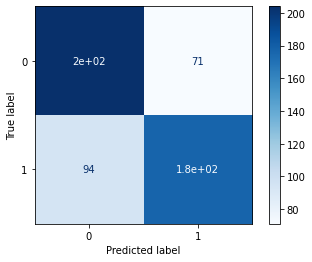

CPU times: user 3.27 s, sys: 1.99 s, total: 5.25 s
Wall time: 2.7 s


In [ ]:
%%time 

print('********************** Logistic Regression **********************')
parameters = {'penalty': ['l2'], 
              'C': [0.001,0.01,0.1,1,10,100,1000]}
 
clf = GridSearchCV(LogisticRegression(max_iter=5000), parameters, cv=5)
# Fir and prediction.
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

print('Best parameters:', clf.best_params_)
print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('Confusion matrix:')
plot_confusion_matrix(clf, x_test, y_test, cmap = 'Blues')  
plt.show() 


********************** SGDClassifier **********************
Best parameters: {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'elasticnet'}
Accuracy:  0.6886446886446886
Confusion matrix:


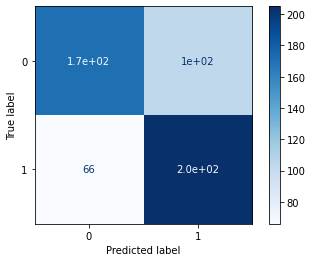

CPU times: user 36.1 s, sys: 15.3 s, total: 51.4 s
Wall time: 34.3 s


In [ ]:
%%time

print('********************** SGDClassifier **********************')
parameters = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], 
              'penalty': ['l2', 'l1', 'elasticnet'],
              'alpha': [1, 0.1, 0.001, 0.001, 0.0001]}
 
clf = GridSearchCV(SGDClassifier(), parameters, cv=5)
# Fir and prediction.
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

print('Best parameters:', clf.best_params_)
print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('Confusion matrix:')
plot_confusion_matrix(clf, x_test, y_test, cmap = 'Blues')  
plt.show() 

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 49.4min finished


********************** RANDOM FOREST **********************
Accuracy:  0.7380952380952381
Confusion matrix:


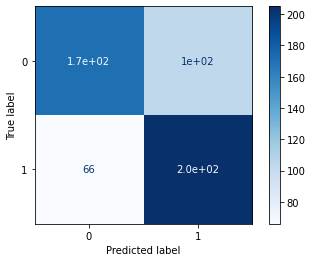

CPU times: user 46.9 s, sys: 241 ms, total: 47.2 s
Wall time: 50min 10s


In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

y_pred = rf_random.predict(x_test)
accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

print('********************** RANDOM FOREST **********************')
print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('Confusion matrix:')
plot_confusion_matrix(clf, x_test, y_test, cmap = 'Blues')  
plt.show() 